In [2]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import dask_geopandas
import contextily as ctx
import seaborn as sns


In [4]:
panel = gpd.read_feather('../data/panel_data_estimated_costs.geofeather')

In [5]:
# Update x, y to be based on parcel shapefile geometry and not tax shapefile geometry
panel['x'] = panel.geometry.centroid.x
panel['y'] = panel.geometry.centroid.y

In [6]:
panel = panel[panel['geometry'].notna()]

### Unit count data

In [72]:
homes = pd.read_excel('../data/Housing Production 2005-2022.xlsx')

In [73]:
dbi = gpd.read_feather('../data/dbi_permits.geofeather')

In [74]:
date_cols = [c for c in dbi.columns if 'date' in c]
dbi[date_cols] = dbi[date_cols].apply(lambda x: pd.to_datetime(x, errors='coerce'))
cost_cols = [c for c in dbi.columns if 'cost' in c]
dbi[cost_cols] = dbi[cost_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
unit_cols = [c for c in dbi.columns if 'unit' in c]
dbi[unit_cols] = dbi[unit_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [75]:
dbi = dbi.sort_values('permit_creation_date', ascending=False)
dbi = dbi.drop_duplicates('permit_number')

# NB: 5 rows in homes don't match-
permits = pd.merge(dbi[['geometry', 'permit_number', 'permit_creation_date']],
                   homes,
                   left_on='permit_number', right_on='BPA', how='inner')
permits = permits[['geometry', 'permit_number', 'Permit Issued Date', 'permit_creation_date',
                   'Net_Units_Completed', 'Date_Completed', 'BlockLot']]


In [76]:
permits = permits[permits['Net_Units_Completed'] > 0]

In [77]:
df_list = []

for year in range(2007, 2017):
    parcels_year = panel[panel.year == year].copy()
    permits_year = permits[permits['permit_creation_date'].dt.year == year].copy()
    df_list.append(gpd.sjoin(parcels_year, permits_year.to_crs(panel.crs), how='left', predicate='contains'))

In [78]:
panel.Developed.sum()

341

In [79]:
result = pd.concat(df_list, axis=0)

In [80]:
nuc_agg = result.groupby(['MapBlkLot_Master', 'year']).agg({'Net_Units_Completed': 'sum'}).reset_index()

In [81]:
result = result.drop_duplicates(['MapBlkLot_Master', 'year'])

In [82]:
result = pd.merge(result.drop(columns='Net_Units_Completed'), nuc_agg, on=['MapBlkLot_Master', 'year'])

In [83]:
result.shape

(1530894, 75)

In [84]:
result = result.drop(columns='index_right')

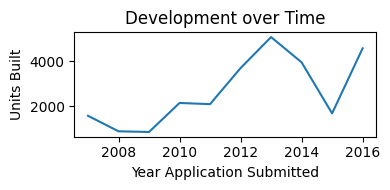

In [130]:
plt.figure(figsize=(4, 2))
plt.plot(result.groupby('year').agg({'Net_Units_Completed': 'sum'}))
plt.ylabel('Units Built')
plt.xlabel('Year Application Submitted')
plt.title('Development over Time')
plt.tight_layout()
plt.savefig('./development_over_time.png')

In [86]:
result.Developed = result.permit_number.notna()

In [87]:
result.Developed.sum()

1831

### EDA

In [88]:
result['revenue'] = result['sqft_price'] * result['Envelope_1000'] * 1000
result['costs'] = result['construction_cost_est'] + result['imputed_fair_market_acquisition']
result['r/c'] = result['revenue'] / result['costs']

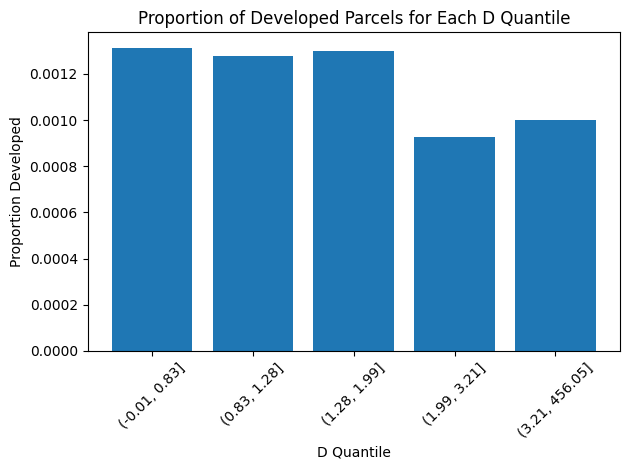

In [166]:
plot_data = result[['r/c', 'Developed']].copy()
plot_data = plot_data[plot_data['r/c'].notna()]
plot_data['r/c'] = pd.qcut(plot_data['r/c'], q=5, precision=2).astype(str)

# Calculate proportion of developed parcels
grouped = plot_data.groupby('r/c')['Developed'].mean().reset_index()
# Plotting
plt.bar(grouped['r/c'], grouped['Developed'])
plt.xlabel('D Quantile')
plt.ylabel('Proportion Developed')
plt.title('Proportion of Developed Parcels for Each D Quantile')
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures that labels fit within the plot area
plt.savefig('d_vs_proportion_developed.png')

In [113]:
result[['revenue']].describe().round(2)

,revenue
count,1.517391e+06
mean,3.026610e+06
std,2.064140e+07
min,0.000000e+00
25%,5.760000e+05
50%,8.320000e+05
75%,1.649993e+06
max,2.600526e+09


In [119]:
result[['construction_cost_est']].describe().round(2)

,construction_cost_est
count,1.530894e+06
mean,8.857822e+05
std,4.886208e+06
min,4.322890e+03
25%,7.823700e+04
50%,1.311089e+05
75%,2.396128e+05
max,8.000000e+08


In [120]:
result.columns

Index(['MapBlkLot_Master', 'year', 'Developed', 'Historic',
       'Residential_Dummy', 'Zillow_Price_Real', 'Const_FedReserve_Real',
       'Envelope_1000', 'Upzone_Ratio', 'zp_OfficeComm', 'zp_DensRestMulti',
       'zp_FormBasedMulti', 'zp_PDRInd', 'zp_Public', 'zp_Redev', 'zp_RH2',
       'zp_RH3_RM1', 'geometry', 'mapblklot', 'property_class_code_definition',
       'lot_code', 'property_area', 'volume_number', 'percent_of_ownership',
       'misc_exemption_value', 'zoning_code', 'year_property_built',
       'analysis_neighborhood', 'number_of_units', 'use_definition',
       'closed_roll_year', 'status_code', 'number_of_bedrooms',
       'assessor_neighborhood', 'number_of_stories',
       'assessor_neighborhood_district', 'exemption_code_definition', 'block',
       'current_sales_date', 'lot_area', 'number_of_rooms', 'lot_depth',
       'assessed_personal_property_value', 'supervisor_district_2012',
       'number_of_bathrooms', 'construction_type', 'lot_frontage',
       'hom

In [121]:
result[['imputed_fair_market_acquisition']].describe().round(2)

,imputed_fair_market_acquisition
count,1.517391e+06
mean,8.484404e+05
std,5.462856e+06
min,1.000000e+00
25%,1.702043e+05
50%,4.189044e+05
75%,7.773547e+05
max,8.680200e+08


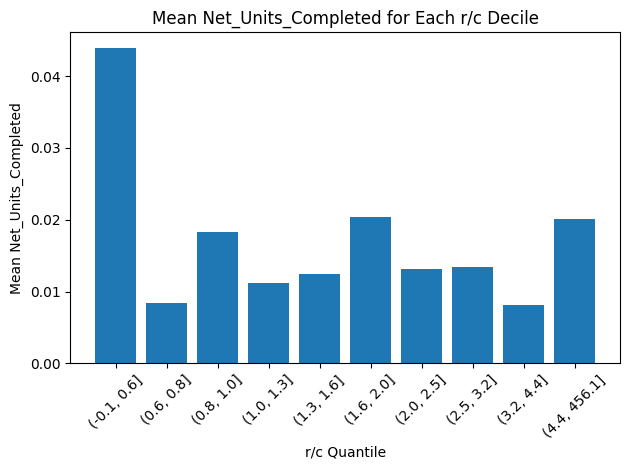

In [93]:
plot_data = result[['r/c', 'Net_Units_Completed']].copy()
plot_data = plot_data[plot_data['r/c'].notna()]
plot_data['r/c'] = pd.qcut(plot_data['r/c'], q=10, precision=1).astype(str)

# Calculate proportion of developed parcels
grouped = plot_data.groupby('r/c')['Net_Units_Completed'].mean().reset_index()
# Plotting
plt.bar(grouped['r/c'], grouped['Net_Units_Completed'])
plt.xlabel('r/c Quantile')
plt.ylabel('Mean Net_Units_Completed')
plt.title('Mean Net_Units_Completed for Each r/c Decile')
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures that labels fit within the plot area
plt.show()

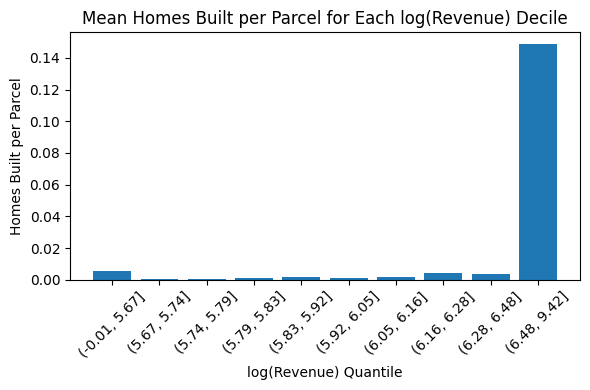

In [116]:
plot_data = result[['revenue', 'Net_Units_Completed']].copy()
plot_data = plot_data[plot_data['revenue'].notna()]
plot_data['revenue'] = pd.qcut(np.log10(1 + plot_data['revenue']), q=10, precision=2).astype(str)

# Calculate proportion of developed parcels
grouped = plot_data.groupby('revenue')['Net_Units_Completed'].mean().reset_index()
# Plotting
plt.figure(figsize=(6, 4))
plt.bar(grouped['revenue'], grouped['Net_Units_Completed'])
plt.xlabel('log(Revenue) Quantile')
plt.ylabel('Homes Built per Parcel')
plt.title('Mean Homes Built per Parcel for Each log(Revenue) Decile')
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures that labels fit within the plot area
plt.savefig('./production_vs_revenue.png')

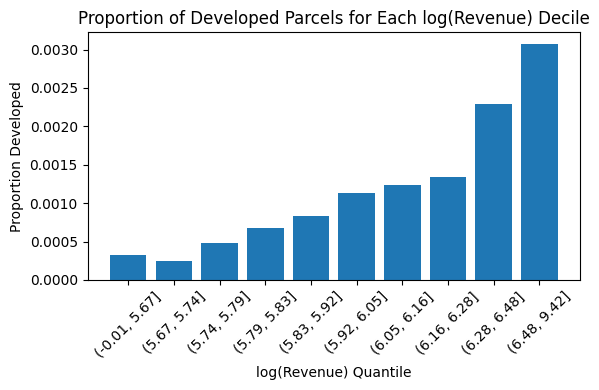

In [117]:
plot_data = result[['revenue', 'Developed']].copy()
plot_data = plot_data[plot_data['revenue'].notna()]
plot_data['revenue'] = pd.qcut(np.log10(1 + plot_data['revenue']), q=10, precision=2).astype(str)

# Calculate proportion of developed parcels
grouped = plot_data.groupby('revenue')['Developed'].mean().reset_index()
# Plotting
plt.figure(figsize=(6, 4))
plt.bar(grouped['revenue'], grouped['Developed'])
plt.xlabel('log(Revenue) Quantile')
plt.ylabel('Proportion Developed')
plt.title('Proportion of Developed Parcels for Each log(Revenue) Decile')
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures that labels fit within the plot area
plt.savefig('./development_vs_revenue.png')

In [62]:
plot_data = panel[['costs', 'Developed']].copy()
plot_data = plot_data[plot_data['costs'].notna()]
plot_data['costs'] = pd.qcut(np.log10(1 + plot_data['costs']), q=10, precision=2).astype(str)

# Calculate proportion of developed parcels
grouped = plot_data.groupby('costs')['Developed'].mean().reset_index()
grouped

,costs,Developed
0,"(4.74, 5.36]",0.000000
1,"(5.36, 5.51]",0.000007
2,"(5.51, 5.62]",0.000000
3,"(5.62, 5.71]",0.000007
4,"(5.71, 5.79]",0.000026
5,"(5.79, 5.87]",0.000040
6,"(5.87, 5.96]",0.000053
7,"(5.96, 6.08]",0.000079
8,"(6.08, 6.3]",0.000461
9,"(6.3, 8.96]",0.001443


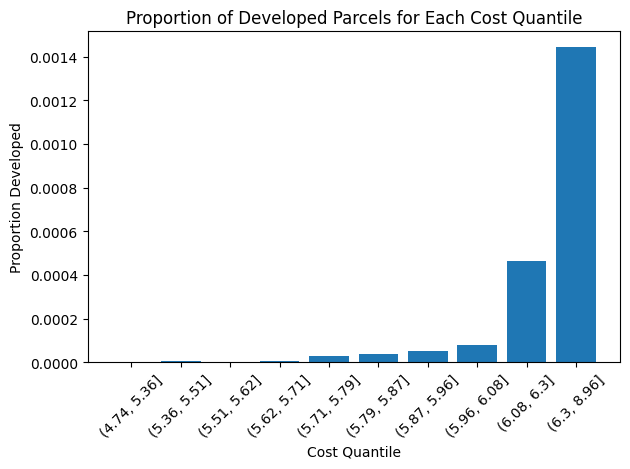

In [63]:
# Plotting
plt.bar(grouped['costs'], grouped['Developed'])
plt.xlabel('Cost Quantile')
plt.ylabel('Proportion Developed')
plt.title('Proportion of Developed Parcels for Each log(Cost) Quantile')
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures that labels fit within the plot area
plt.show()

/var/folders/3l/rp3b9_z94lz520zv0rrb_0ww0000gn/T/ipykernel_52119/2884841214.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = grouped.pivot('costs_tercile', 'revenue_tercile', 'Developed')


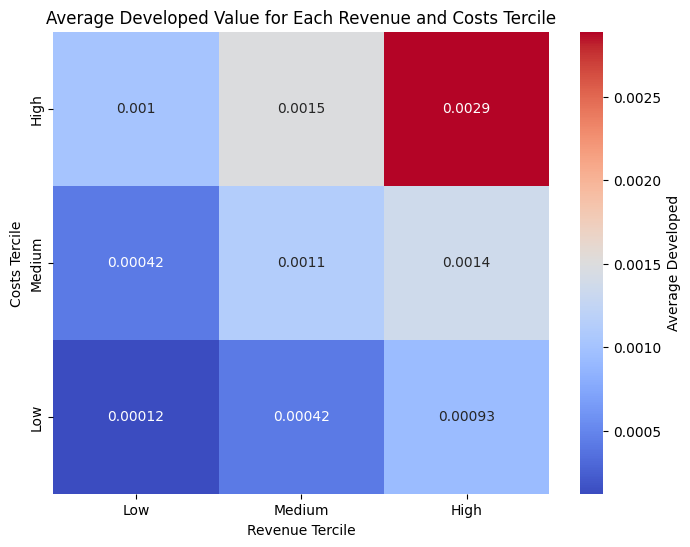

In [155]:
df = result[['revenue', 'costs', 'Developed', 'Net_Units_Completed']].copy()
# Create terciles for 'revenue' and 'costs'
df['revenue_tercile'] = pd.qcut(df['revenue'], q=3, labels=['Low', 'Medium', 'High'])
df['costs_tercile'] = pd.qcut(df['costs'], q=3, labels=['Low', 'Medium', 'High'])

# Calculate the average 'Developed' value for each (revenue_tercile, costs_tercile) pair
grouped = df.groupby(['revenue_tercile', 'costs_tercile'])['Developed'].mean().reset_index()

# Pivot the DataFrame to create a matrix suitable for a heatmap
heatmap_data = grouped.pivot('costs_tercile', 'revenue_tercile', 'Developed')
heatmap_data.sort_index(axis=0, ascending=False, inplace=True)
heatmap_data.sort_index(axis=1, ascending=True, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Average Developed'})
plt.title('Average Developed Value for Each Revenue and Costs Tercile')
plt.xlabel('Revenue Tercile')
plt.ylabel('Costs Tercile')
plt.show()

  revenue_tercile costs_tercile  Developed
0             Low           Low   0.000121
1             Low        Medium   0.000424
2             Low          High   0.001009
3          Medium           Low   0.000417
4          Medium        Medium   0.001118
5          Medium          High   0.001489
6            High           Low   0.000928
7            High        Medium   0.001365
8            High          High   0.002891


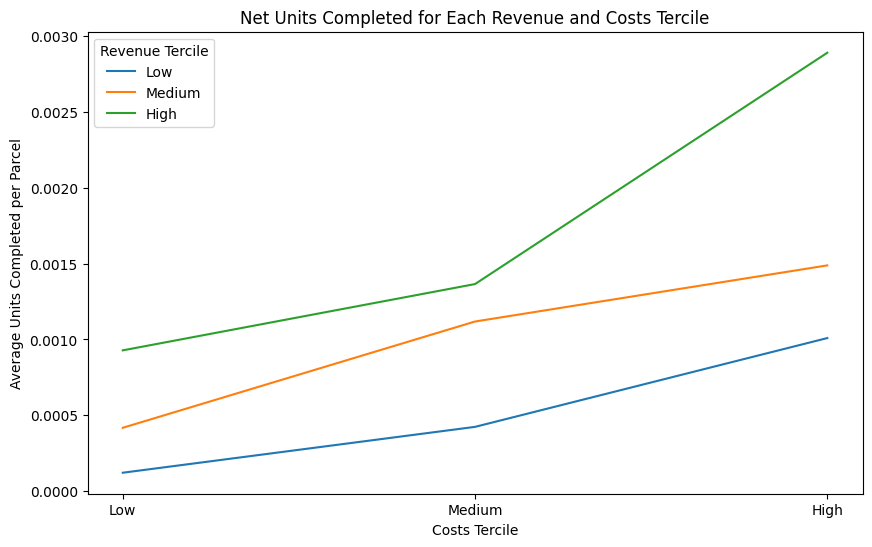

In [158]:
# Group data by 'revenue_tercile' and 'costs_tercile' and calculate the mean of 'net_units_completed'
grouped = df.groupby(['revenue_tercile', 'costs_tercile'])['Developed'].mean().reset_index()

print(grouped)
# Create the plot
plt.figure(figsize=(10, 6))

for label, df_subset in grouped.groupby('revenue_tercile'):
    plt.plot(df_subset['costs_tercile'], df_subset['Developed'], label=label)

plt.title('Net Units Completed for Each Revenue and Costs Tercile')
plt.xlabel('Costs Tercile')
plt.ylabel('Average Units Completed per Parcel')
plt.legend(title='Revenue Tercile')

  revenue_tercile costs_tercile  Net_Units_Completed
0             Low           Low             0.000125
1             Low        Medium             0.000445
2             Low          High             0.013888
3          Medium           Low             0.000423
4          Medium        Medium             0.001152
5          Medium          High             0.003190
6            High           Low             0.001027
7            High        Medium             0.001802
8            High          High             0.082554


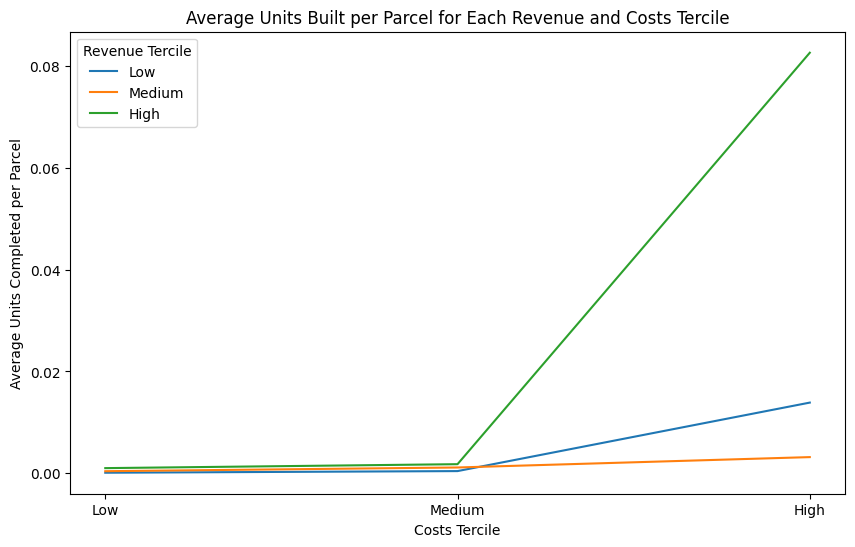

In [163]:
# Group data by 'revenue_tercile' and 'costs_tercile' and calculate the mean of 'net_units_completed'
grouped = df.groupby(['revenue_tercile', 'costs_tercile'])['Net_Units_Completed'].mean().reset_index()

print(grouped)
# Create the plot
plt.figure(figsize=(10, 6))

for label, df_subset in grouped.groupby('revenue_tercile'):
    plt.plot(df_subset['costs_tercile'], df_subset['Net_Units_Completed'], label=label)

plt.title('Average Units Built per Parcel for Each Revenue and Costs Tercile')
plt.xlabel('Costs Tercile')
plt.ylabel('Average Units Completed per Parcel')
plt.legend(title='Revenue Tercile')
plt.savefig('./revenue_vs_cost_interact.png')

/var/folders/3l/rp3b9_z94lz520zv0rrb_0ww0000gn/T/ipykernel_52119/3574695258.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = grouped.pivot('costs_tercile', 'revenue_tercile', 'Net_Units_Completed')


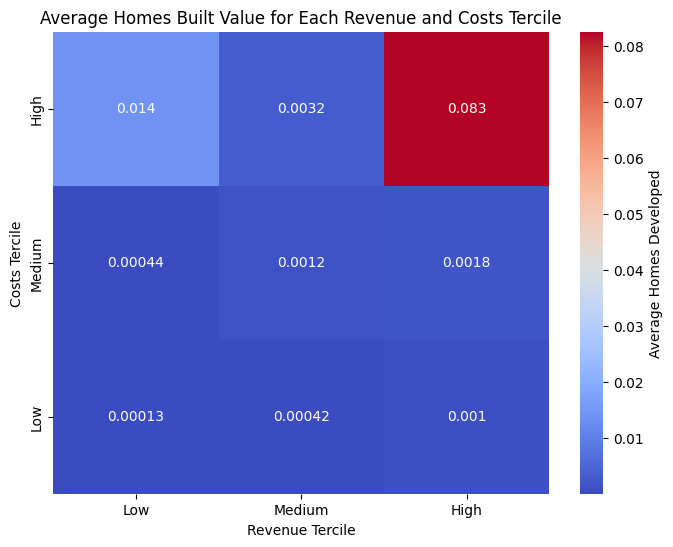

In [101]:
df = result[['revenue', 'costs', 'Developed', 'Net_Units_Completed']].copy()
# Create terciles for 'revenue' and 'costs'
df['revenue_tercile'] = pd.qcut(df['revenue'], q=3, labels=['Low', 'Medium', 'High'])
df['costs_tercile'] = pd.qcut(df['costs'], q=3, labels=['Low', 'Medium', 'High'])

# Calculate the average 'Developed' value for each (revenue_tercile, costs_tercile) pair
grouped = df.groupby(['revenue_tercile', 'costs_tercile'])['Net_Units_Completed'].mean().reset_index()

# Pivot the DataFrame to create a matrix suitable for a heatmap
heatmap_data = grouped.pivot('costs_tercile', 'revenue_tercile', 'Net_Units_Completed')
heatmap_data.sort_index(axis=0, ascending=False, inplace=True)
heatmap_data.sort_index(axis=1, ascending=True, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Average Homes Developed'})
plt.title('Average Homes Built Value for Each Revenue and Costs Tercile')
plt.xlabel('Revenue Tercile')
plt.ylabel('Costs Tercile')
plt.show()

In [3]:
panel.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

/var/folders/3l/rp3b9_z94lz520zv0rrb_0ww0000gn/T/ipykernel_52119/776912649.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Ensures that labels fit within the plot area


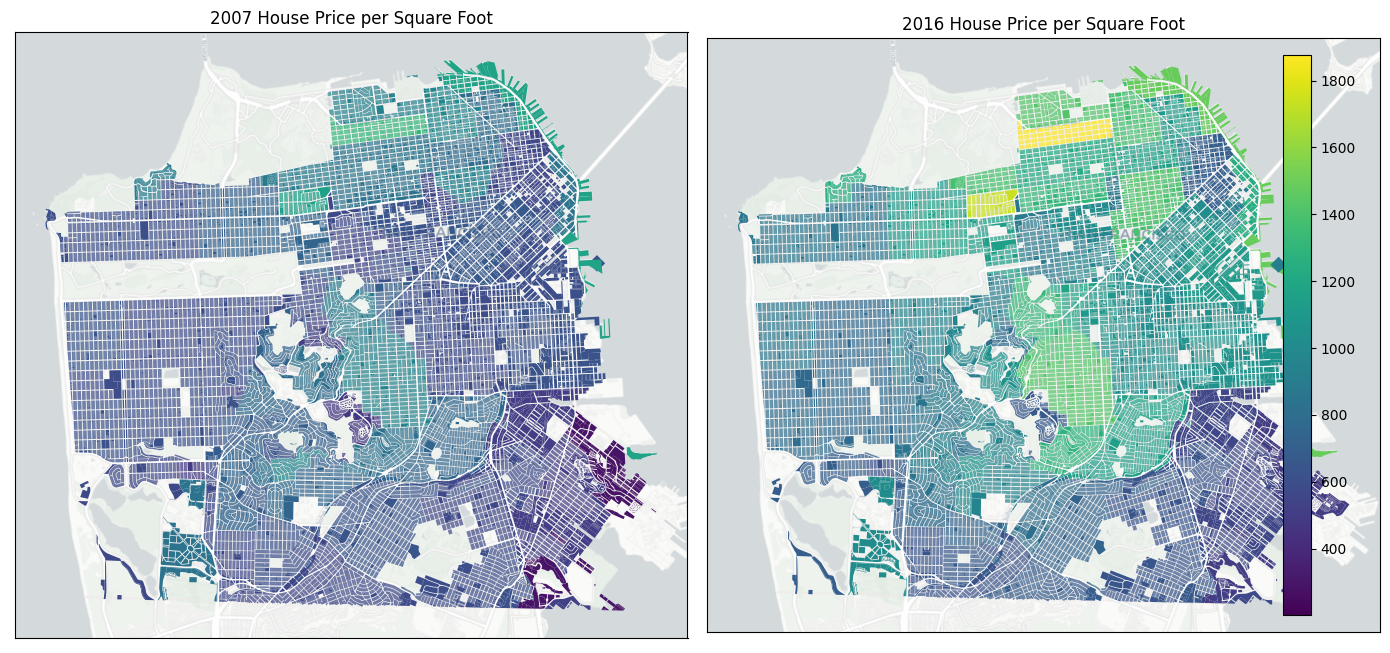

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
vmin, vmax = panel['sqft_price'].min(), panel['sqft_price'].max()

ax1 = panel.query('closed_roll_year == 2016').plot(column='sqft_price', legend=False, ax=axes[1], vmin=vmin, vmax=vmax)
ctx.add_basemap(crs=3310, attribution=False, source=ctx.providers.CartoDB.Positron, ax=axes[1])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("2016 House Price per Square Foot")

ax2 = panel.query('closed_roll_year == 2007').plot(column='sqft_price', legend=False, ax=axes[0], vmin=vmin, vmax=vmax)
ctx.add_basemap(crs=3310, attribution=False, source=ctx.providers.CartoDB.Positron, ax=axes[0])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("2007 House Price per Square Foot")

cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
fig.colorbar(sm, cax=cax)

plt.tight_layout()  # Ensures that labels fit within the plot area
plt.savefig('combined_sqft_price.png')

In [132]:
panel.columns

Index(['MapBlkLot_Master', 'year', 'Developed', 'Historic',
       'Residential_Dummy', 'Zillow_Price_Real', 'Const_FedReserve_Real',
       'Envelope_1000', 'Upzone_Ratio', 'zp_OfficeComm', 'zp_DensRestMulti',
       'zp_FormBasedMulti', 'zp_PDRInd', 'zp_Public', 'zp_Redev', 'zp_RH2',
       'zp_RH3_RM1', 'geometry', 'mapblklot', 'property_class_code_definition',
       'lot_code', 'property_area', 'volume_number', 'percent_of_ownership',
       'misc_exemption_value', 'zoning_code', 'year_property_built',
       'analysis_neighborhood', 'number_of_units', 'use_definition',
       'closed_roll_year', 'status_code', 'number_of_bedrooms',
       'assessor_neighborhood', 'number_of_stories',
       'assessor_neighborhood_district', 'exemption_code_definition', 'block',
       'current_sales_date', 'lot_area', 'number_of_rooms', 'lot_depth',
       'assessed_personal_property_value', 'supervisor_district_2012',
       'number_of_bathrooms', 'construction_type', 'lot_frontage',
       'hom

,MapBlkLot_Master,year,Developed,Historic,Residential_Dummy,Zillow_Price_Real,Const_FedReserve_Real,Envelope_1000,Upzone_Ratio,zp_OfficeComm,...,construction_cost_est,revenue,costs,r/c,permit_number,Permit Issued Date,permit_creation_date,Date_Completed,BlockLot,Net_Units_Completed
24338,2374019,2007.0,True,0,1,93.227099,92.120253,3.124987,1.666667,0,...,1.374000e+06,1.943742e+06,1.495900e+06,1.299380,200712120290,2016-04-01,2007-12-12,2017-12-14,2374019,3.0
25411,2347004G,2007.0,True,0,0,93.227099,92.120253,2.000000,0.290910,0,...,6.112000e+06,1.244000e+06,7.015509e+06,0.177321,200708079019,2014-07-11,2007-08-07,2020-07-20,2347004G,10.0
25602,4084022,2007.0,True,1,1,93.227099,92.120253,2.863737,2.000000,0,...,2.550000e+05,1.672423e+06,9.250000e+05,1.808024,200702164309,2007-08-21,2007-02-16,2008-06-20,4084022,1.0
27612,4210013,2007.0,True,1,1,93.227099,92.120253,2.000000,0.649984,0,...,7.500000e+04,1.168000e+06,6.114658e+05,1.910164,200710155355,2010-01-25,2007-10-15,2017-01-27,4210013,1.0
27867,4206040,2007.0,True,0,1,93.227099,92.120253,3.900014,0.449518,0,...,2.500000e+04,2.277608e+06,1.119650e+06,2.034214,200708281138,2008-04-08,2007-08-28,2008-10-09,4206040,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527370,3123004,2016.0,True,0,1,100.000000,100.000000,1.000000,0.533334,0,...,7.000000e+04,9.660000e+05,8.056625e+05,1.199013,201606018866,2016-11-03,2016-06-01,2017-03-31,3123004,1.0
1527865,3089065,2016.0,True,0,1,100.000000,100.000000,1.000000,0.477309,0,...,5.400000e+04,9.660000e+05,5.020125e+05,1.924255,201609268810,2017-09-29,2016-09-26,2018-05-15,3089065,1.0
1530068,7178014,2016.0,True,0,0,100.000000,100.000000,1.000000,0.725701,0,...,4.039364e+04,6.420000e+05,1.755764e+06,0.365653,201610200843,2019-07-18,2016-10-20,2021-11-19,7178001,1.0
1530319,1705052,2016.0,True,0,1,100.000000,100.000000,2.000000,0.939850,0,...,1.400000e+05,1.724000e+06,7.790927e+05,2.212830,201607142358,2017-05-26,2016-07-14,2019-05-08,1705028,1.0


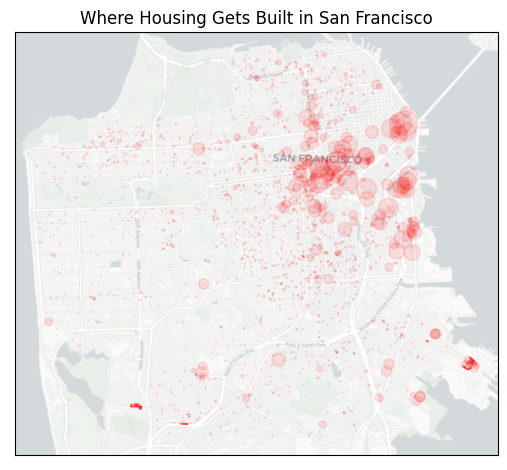

In [152]:
built = result[result.Net_Units_Completed > 0].copy()
built['log(Units Built)'] = np.log10(built.Net_Units_Completed)
ax1 = built['geometry'].centroid.plot(marker='o', color='red', markersize=built.Net_Units_Completed*.5, alpha=.1, label="Centroid")
ctx.add_basemap(crs=3310, attribution=False, source=ctx.providers.CartoDB.Positron, ax=ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Where Housing Gets Built in San Francisco")
plt.tight_layout()
plt.savefig('./where_housing_gets_built.png')

### Fires

In [23]:
fires = gpd.read_feather('../data/clean_accidental_fires.geofeather')

In [24]:
fires.to_crs(result.crs, inplace=True)

In [25]:
panel_fires = gpd.sjoin(result,
                        fires[['geometry',
                               'estimated_property_loss',
                               'incident_date']].rename(columns= 
                                                        {'estimated_property_loss' : 'fire_damage', 
                                                         'incident_date': 'fire_date'}), 
                        how='left',
                        predicate='contains')

In [26]:
panel_fires.index_right.notna().sum()

3479

In [19]:
panel_fires.drop_duplicates('MapBlkLot_Master')[
    (panel_fires.drop_duplicates('MapBlkLot_Master').fire_damage > 0)
].fire_damage.describe()

count    3.020000e+02
mean     8.874000e+04
std      7.718217e+05
min      1.000000e+00
25%      5.000000e+02
50%      2.000000e+03
75%      1.150000e+04
max      1.320000e+07
Name: fire_damage, dtype: float64

In [27]:
panel_fires = panel_fires.drop(columns=['index_right'])

In [28]:
panel_fires.fire_damage.fillna(0, inplace=True)

In [29]:
panel_fires['years_since_fire'] = panel_fires.year - panel_fires.fire_date.dt.year

In [30]:
panel_fires['years_since_fire'][panel_fires['years_since_fire'].notna()]

278        -4.0
1982       -7.0
5338      -11.0
10078      -6.0
11812     -10.0
           ... 
1526412    -5.0
1526466     9.0
1528836    -1.0
1529871    -6.0
1530706    11.0
Name: years_since_fire, Length: 3479, dtype: float64

In [31]:
panel_fires['years_since_fire'][panel_fires['years_since_fire'].notna()].describe()

count    3479.000000
mean        0.574590
std         6.663876
min       -16.000000
25%        -4.000000
50%         2.000000
75%         6.000000
max        13.000000
Name: years_since_fire, dtype: float64

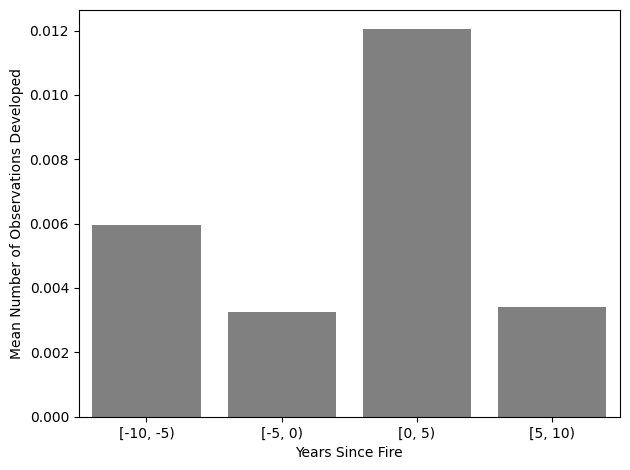

In [10]:
# Compute the mean for each unique value of 'years_since_fire'
to_plot = panel_fires.copy()
to_plot['years_since_fire_bucket'] = pd.cut(to_plot['years_since_fire'], bins=range(-10, 11, 5), right=False)
to_plot = to_plot.groupby('years_since_fire_bucket')['Developed'].mean().reset_index()

# Plot using seaborn
sns.barplot(x='years_since_fire_bucket', y='Developed', data=to_plot, color='grey')
plt.ylabel('Mean Number of Observations Developed')
plt.xlabel('Years Since Fire')
plt.tight_layout()
plt.savefig('./dev_after_fire.png')

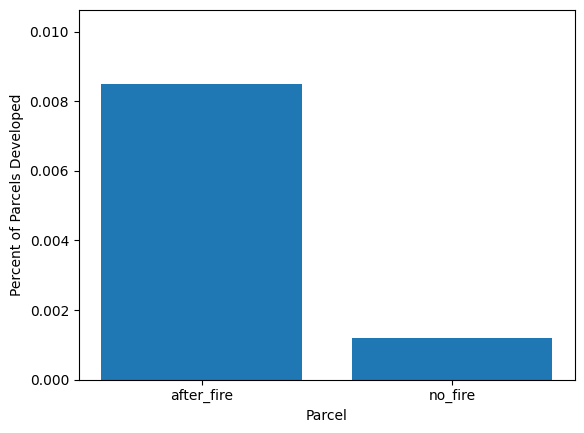

In [16]:
panel_fires['fire_category'] = np.where(panel_fires['years_since_fire'].fillna(-1) < 0, 'no_fire', 'after_fire')

# Compute the mean for each category
plot_data = panel_fires.groupby('fire_category')['Developed'].mean().reset_index()

plot_data
# Plot using matplotlib
plt.bar(plot_data['fire_category'], plot_data['Developed'])

# Set y-axis limit to 110% of the maximum value
plt.ylim(0, plot_data['Developed'].max() * 1.25)

plt.ylabel('Percent of Parcels Developed')
plt.xlabel('Parcel')
plt.savefig('dev_fire_fstat.png')

In [18]:
0.008499 / 0.001190

7.142016806722689

### Revenue & Cost

In [64]:
panel_fires['revenue'] = panel_fires['sqft_price'] * panel_fires['Envelope_1000'] * 1000 / 30

In [65]:
panel_fires.columns

Index(['MapBlkLot_Master', 'year', 'Developed', 'Historic',
       'Residential_Dummy', 'Zillow_Price_Real', 'Const_FedReserve_Real',
       'Envelope_1000', 'Upzone_Ratio', 'zp_OfficeComm', 'zp_DensRestMulti',
       'zp_FormBasedMulti', 'zp_PDRInd', 'zp_Public', 'zp_Redev', 'zp_RH2',
       'zp_RH3_RM1', 'geometry', 'mapblklot', 'property_class_code_definition',
       'lot_code', 'property_area', 'volume_number', 'percent_of_ownership',
       'misc_exemption_value', 'zoning_code', 'year_property_built',
       'analysis_neighborhood', 'number_of_units', 'use_definition',
       'closed_roll_year', 'status_code', 'number_of_bedrooms',
       'assessor_neighborhood', 'number_of_stories',
       'assessor_neighborhood_district', 'exemption_code_definition', 'block',
       'current_sales_date', 'lot_area', 'number_of_rooms', 'lot_depth',
       'assessed_personal_property_value', 'supervisor_district_2012',
       'number_of_bathrooms', 'construction_type', 'lot_frontage',
       'hom

In [66]:
panel_fires['costs'] = (panel_fires['construction_cost_est'] 
                        + np.maximum(panel_fires['imputed_fair_market_acquisition'] - panel_fires['fire_damage'], 0))

In [67]:
panel_fires['costs']

0          2.495993e+07
1          5.287091e+07
2          3.151963e+05
3          1.025149e+06
4          7.382555e+05
               ...     
1530789    6.903314e+05
1530790    2.785223e+06
1530791    1.040481e+06
1530792    1.891363e+06
1530793             NaN
Name: costs, Length: 1531273, dtype: float64

In [68]:
panel_fires['revenue'] 

0          3.372075e+06
1          2.744964e+06
2          3.782784e+04
3          3.927322e+04
4          5.971198e+04
               ...     
1530789    1.250667e+05
1530790    1.293656e+05
1530791    1.421000e+05
1530792    4.898656e+05
1530793             NaN
Name: revenue, Length: 1531273, dtype: float64

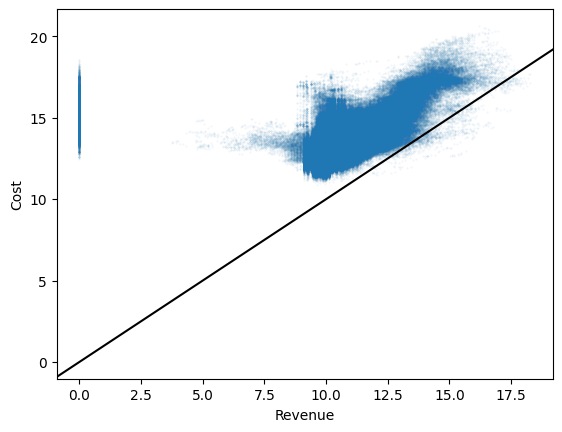

In [69]:
f, ax = plt.subplots()
plt.scatter(np.log1p(panel_fires['revenue']), np.log1p(panel_fires['costs']), alpha=.1, s=.1)
plt.xlabel('Revenue')
plt.ylabel('Cost')
ax.axline((0, 0), slope=1, color='black')
plt.show()

In [55]:
panel_fires['fire_damage'].max()

13200000.0

In [39]:
panel_fires['revenue'].max()

2600526059.778

KeyboardInterrupt: 

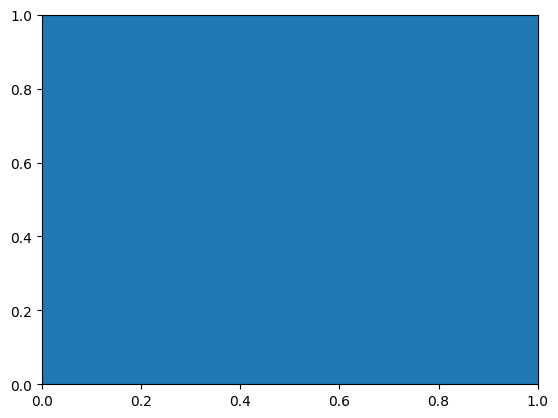

In [40]:
plt.hist(np.log1p(panel_fires['revenue'] / panel_fires['costs']), bins=40)
plt.xlim(0, 100)

In [ ]:
result = panel_fires.groupby('Developed').apply(lambda x: (x['revenue'] / x['costs']).mean())

# Create the bar plot
result.plot(kind='bar', ylabel='Mean Revenue / Costs', title='Mean Revenue Divided by Costs for Developed and Not Developed Groups')
plt.xticks(ticks=[0, 1], labels=['Not Developed', 'Developed'], rotation=0)
plt.show()

In [3]:
panel_fires = pd.read_csv('./panel_fires.csv')

/var/folders/3l/rp3b9_z94lz520zv0rrb_0ww0000gn/T/ipykernel_47521/3647980955.py:1: DtypeWarning: Columns (37,66,67,68,69,72) have mixed types. Specify dtype option on import or set low_memory=False.
  panel_fires = pd.read_csv('./panel_fires.csv')


In [ ]:
panel_fires.to_csv('./panel_fires.csv', index=False)